Monthly Forecast - Time Series

In [47]:
#Importing Necessary Libraries

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats.mstats import winsorize
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa import stattools
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import os, random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os, random
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from skopt import BayesSearchCV

# 1. Data Exploration and Cleaning

I'll start by analyzing the monthly sales data (X12_1).

Steps:
- Load & Explore Data – Check for missing values, trends, and seasonality.
- Preprocess Data – Handle missing values, outliers, and transform if necessary.



In [48]:
# Checking the dimensionality and metadata of the data.
#Loading the data sets
data_x12_1 = pd.read_csv("DSAssignment_X12_1_monthly.csv")
data_x12_1.head()
data_x12_1.shape
data_x12_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   YM       101 non-null    object
 1   Product  101 non-null    object
 2   Qty      101 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


The _YM_  column is object format and must be converted to datetime. Let's sort that by _Year-Month_ following that.

In [49]:
df_monthly = data_x12_1.copy()

# Convert 'Year-Month' to datetime format
df_monthly['Year-Month'] = pd.to_datetime(df_monthly['YM'], format='%Y-%m')
# Sort data by date
df_monthly = df_monthly.sort_values(by="Year-Month").reset_index(drop=True)



In [50]:
df_monthly.isna().sum()

YM            0
Product       0
Qty           0
Year-Month    0
dtype: int64

No _Null_ Values detected.

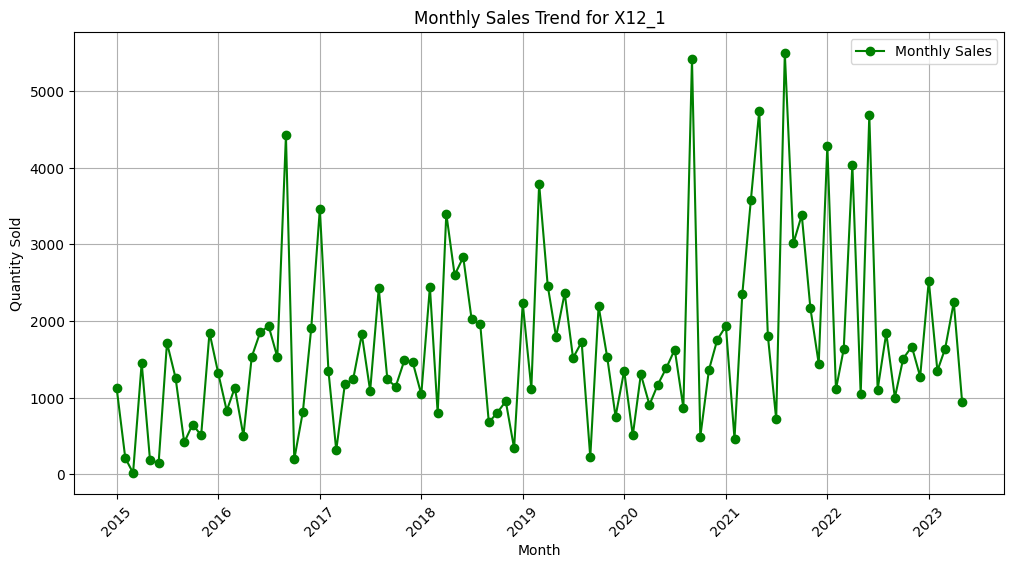

In [51]:
#Plotting the trends of the demand/sales for the product

plt.figure(figsize=(12, 6))
plt.plot(df_monthly['Year-Month'], df_monthly['Qty'], marker='o', linestyle='-', color='g', label='Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.title('Monthly Sales Trend for X12_1')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# **Insights from Monthly Sales Trend for X12_1**

1. **High Volatility in Sales**  
   - The sales data exhibits significant fluctuations, with multiple sharp spikes and drops.  
   - Periodic peaks suggest seasonal demand patterns, indicating that a **SARIMA or Exponential Smoothing model** might be suitable for forecasting.

2. **Increasing Trend with Seasonal Spikes**  
   - There is an overall upward trend in sales, with **more frequent and higher peaks in later years (2020-2022)**.  
   - This suggests potential growth in demand, possibly driven by external factors like promotions, market expansion, or economic changes.

3. **Periods of Low Demand**  
   - There are multiple instances where sales drop close to zero, which could indicate **stockouts, seasonal dips, or market disruptions**.  
   - Handling these anomalies is crucial for improving forecast accuracy

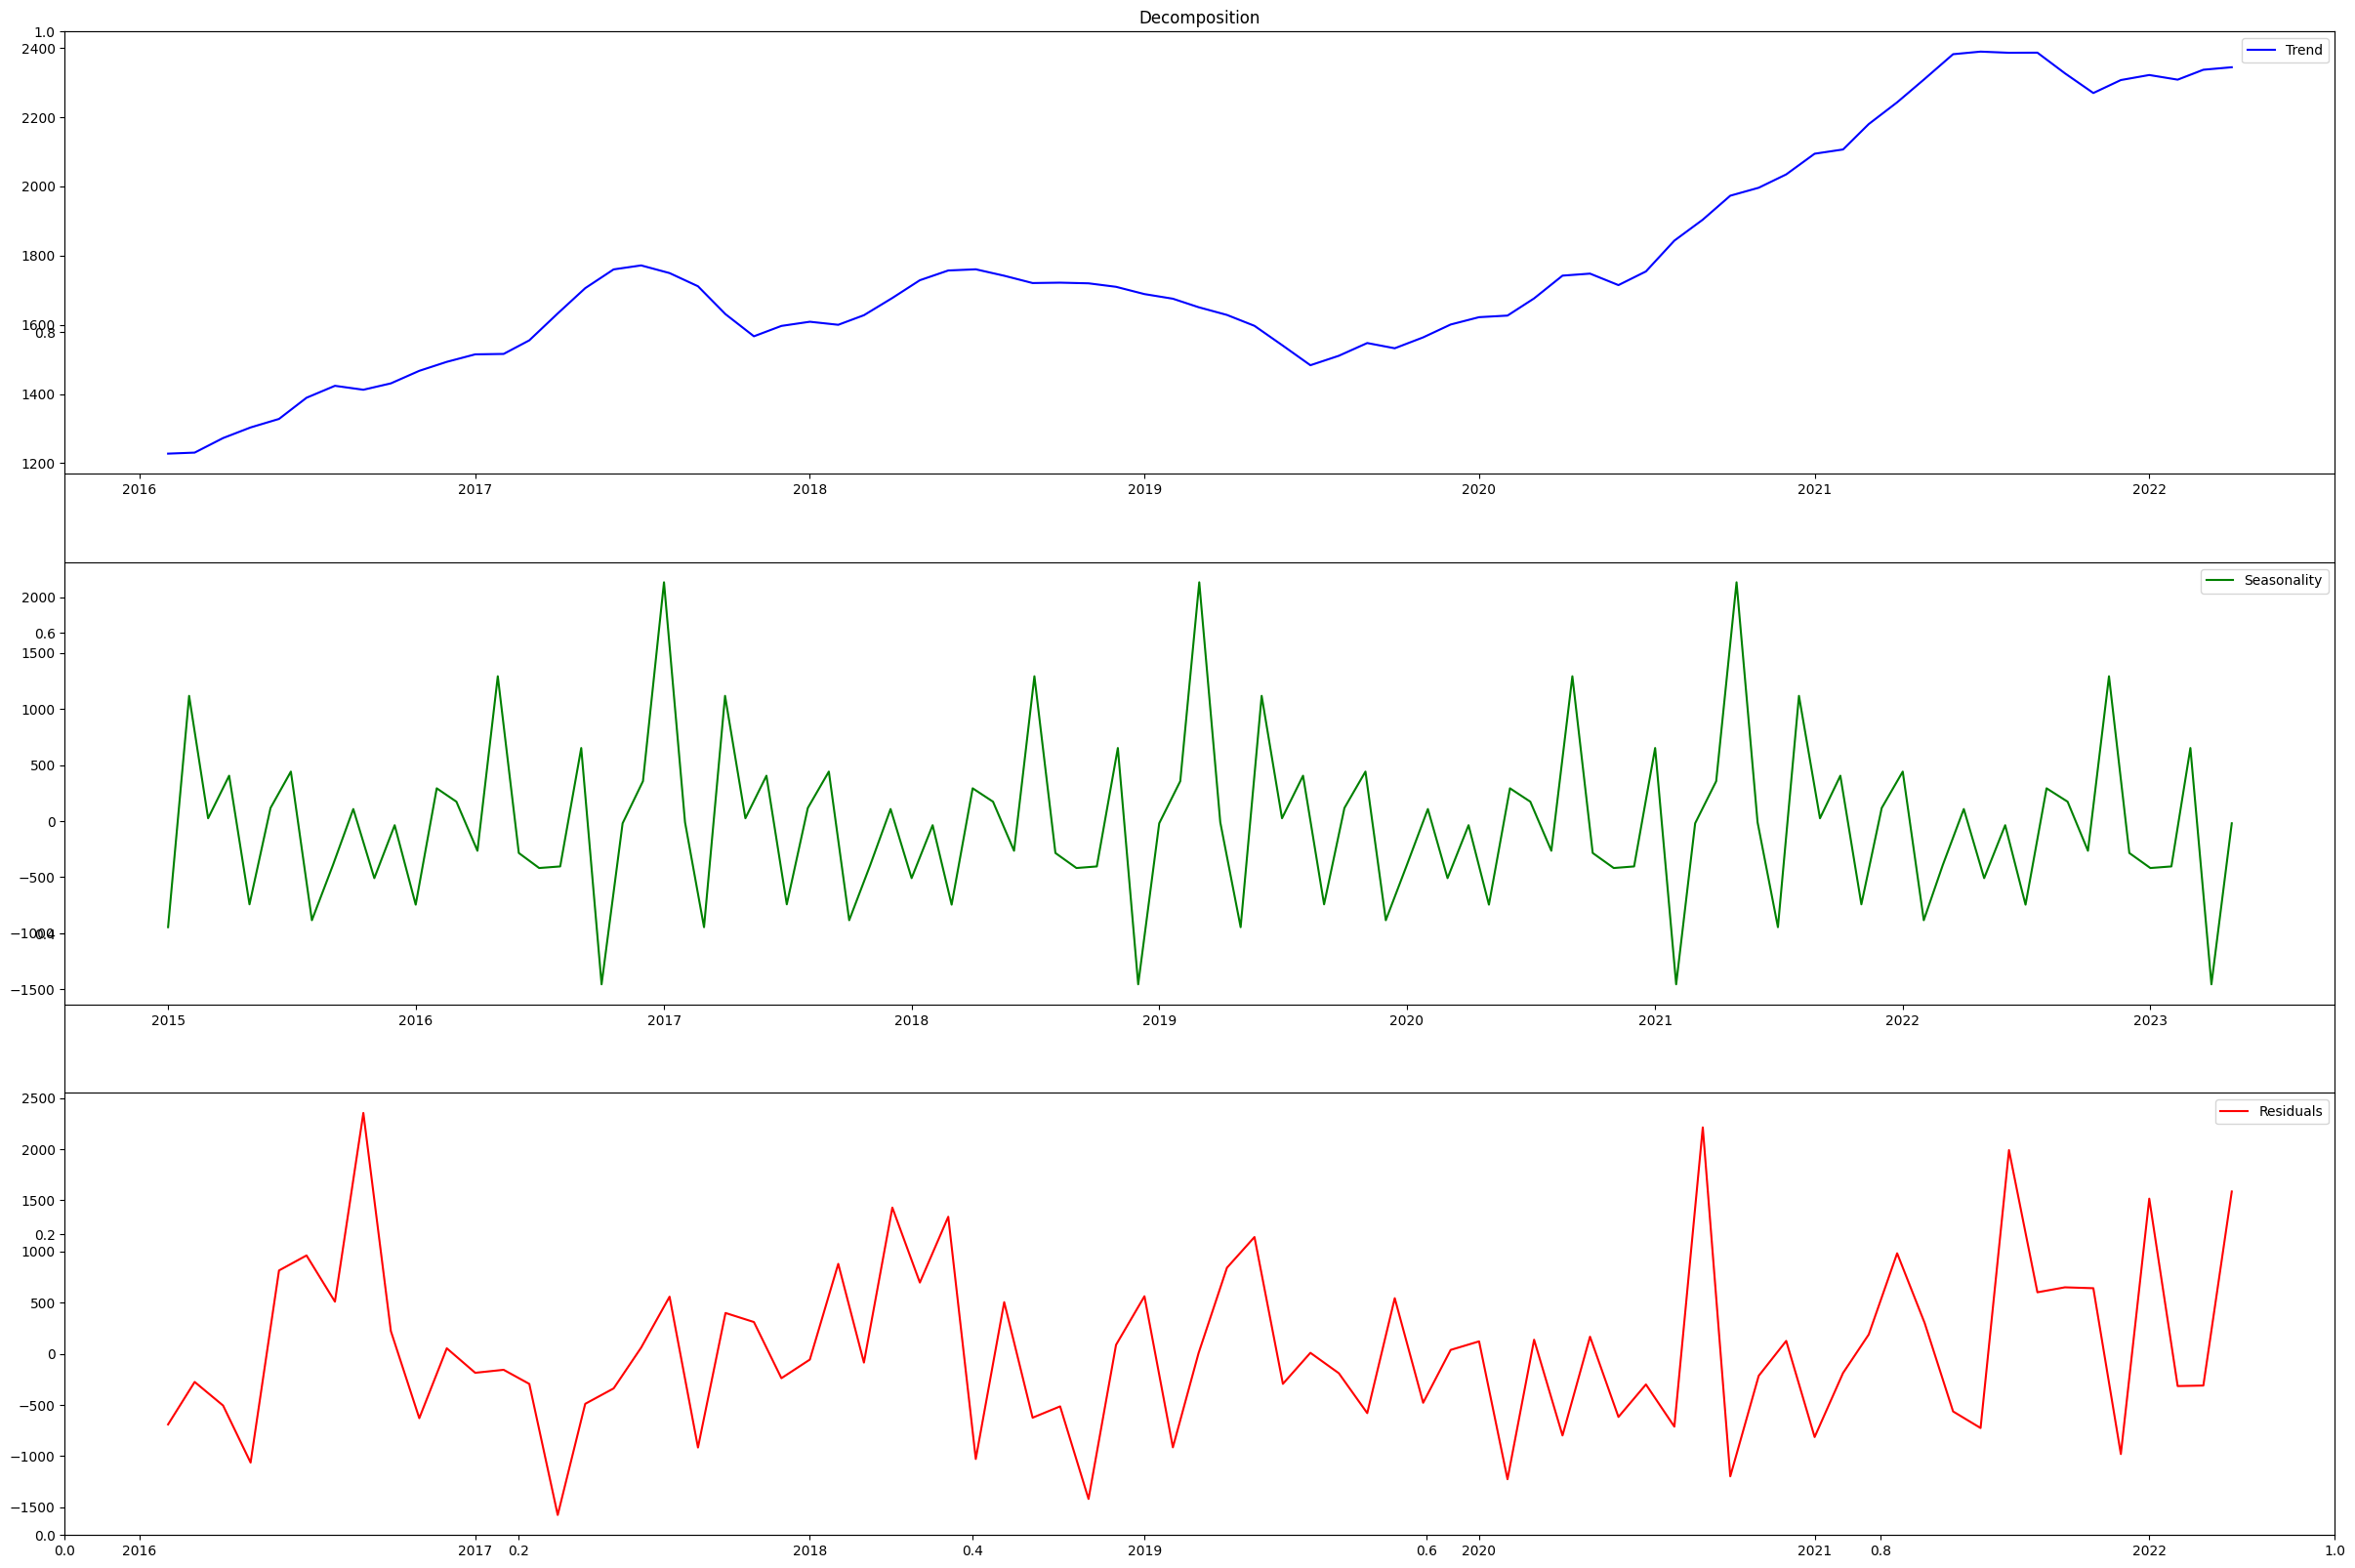

In [52]:
# Plotting the seasonal decomposition of the trends
decomposition = seasonal_decompose(df_monthly.set_index('Year-Month')['Qty'], model='additive', period=26) # Assuming Half year seasonality

# Plot decomposition
plt.figure(figsize=(30, 20))
plt.title("Decomposition")
plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend()

## Trend Component (Top Plot - Blue Line)
- The trend indicates a **steady increase in demand from 2015 to 2023**, with occasional slowdowns.
- A notable **dip occurs between 2018 and 2019**, followed by a strong recovery and a peak in 2021.
- Recent data suggests **stabilization** at a high level, meaning growth may be plateauing.

Implication:  
The model should account for **trend shifts** and avoid assuming continuous growth.

---

## Seasonal Component (Middle Plot - Green Line)
- Clear **seasonal patterns** are present, suggesting **cyclical fluctuations in demand**.
- Peaks and troughs **repeat consistently**, confirming the importance of **seasonality in forecasting**.
- The amplitude of seasonal variation fluctuates over time, indicating potential **changes in demand intensity across years**.

Implication:
A **seasonal model (SARIMA, Prophet, or Fourier terms in ML models)** should be used to capture recurring demand cycles.

---

## Residual Component (Bottom Plot - Red Line)
- Residuals show **significant variability**, meaning that some demand fluctuations remain unexplained by trend and seasonality.
- Large spikes suggest the presence of **external events, anomalies, or one-time demand shocks**.
- Residual variance **increases over time**, indicating **potential non-stationarity** in variance.

Implication:  
- The model may need **outlier handling** to reduce forecast errors.
- **Heteroscedasticity (variance changes over time) may require transformations** like log-scaling or differencing.

---

# Conclusion
- The data exhibits **a strong upward trend, significant seasonality, and volatile residuals**.
- A **SARIMA or Prophet model** is likely needed to handle **trend & seasonality effectively**.
- **Residual spikes indicate external factors**—incorporating macroeconomic indicators or special events might improve forecast accuracy.


In [53]:
# Check for stationarity using the Augmented Dickey-Fuller (ADF) test

adf_test_new = stattools.adfuller(df_monthly['Qty'])
adf_test_results_new = {
    "ADF Statistic": adf_test_new[0],
    "p-value": adf_test_new[1],
    "Critical Values": adf_test_new[4]
}

adf_test_results_new

{'ADF Statistic': -9.428401195786904,
 'p-value': 5.270126192911079e-16,
 'Critical Values': {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349}}

Here, the Augmented Dickey-Fuller (ADF) test is used to check whether a time series is stationary or not. Stationarity means that the statistical properties (mean, variance, autocorrelation) do not change over time, which is crucial for time series forecasting.

- Since the p-value is below 0.05, the time series is stationary, meaning differencing (d) in ARIMA may not be required.

- If using statistical models like ARIMA, We can use ARMA (p, q) models instead of ARIMA.

- I'll also explore Prophet and LSTM as the data does not exhibit a strong trend requiring transformation.

Before, moving on to model development, I'll also check the outliers.. (Just want to see how many outliers are present)


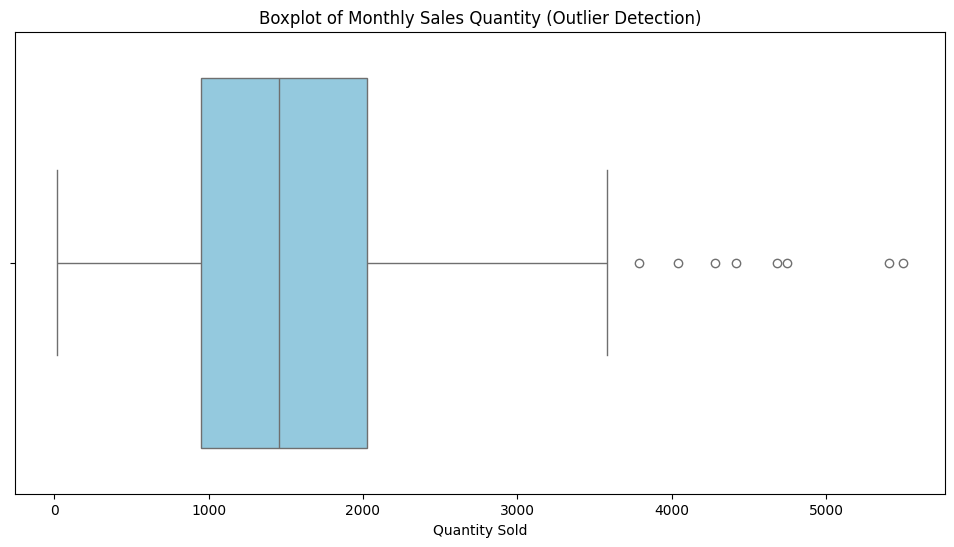

The Median Sales is:


1455.0

In [54]:
Q1 = df_monthly['Qty'].quantile(0.25)
Q3 = df_monthly['Qty'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 *IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers instead of displaying all to reduce memory usage
num_outliers = ((df_monthly['Qty'] < lower_bound) | (df_monthly['Qty'] > upper_bound)).sum()

# Summary of outliers
outlier_summary = {
    "Lower Bound": lower_bound,
    "Upper Bound": upper_bound,
    "Number of Outliers": num_outliers
}

outlier_summary

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the boxplot to visualize outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_monthly['Qty'], color='skyblue')
plt.title("Boxplot of Monthly Sales Quantity (Outlier Detection)")
plt.xlabel("Quantity Sold")
plt.show()

print("The Median Sales is:")
df_monthly["Qty"].median()

Now, Similar to the weekly sales prediction  I will winsorize the Outliers instead removing them.

Winsorization is a statistical technique used to limit the effect of extreme values (outliers) in a dataset by replacing them with the nearest non-extreme values. Instead of removing outliers, Winsorization smooths extreme values to reduce their influence.

WHY?
- Forecasting models should **generalize well to unseen data**.
- Keeping extreme outliers **harms prediction accuracy for most cases**.



In [55]:
# Apply Winsorization (limits extreme values at the 5th and 95th percentile)
df_monthly['Quantity_Winsorized'] = winsorize(df_monthly['Qty'], limits=[0.05, 0.05])
df_monthly["Qty"] = df_monthly["Quantity_Winsorized"]
df_monthly.drop(["Quantity_Winsorized"],axis=1, inplace=True)

The data lacks a lot of time based features. Since this is something time dependent, adding time-based features can help the model understand and capture timely patterns, be it annual/quarterly.

The below are the features I am adding:
- *Month of the Year* - 	Helps detect monthly demand variations.
- *Quarter of the Year* - 	Useful for tracking quarterly trends.
- *Year* -	Captures long-term trends in sales growth.

These are the features I am creating for the ML Model I will be using, as I want to use LSTM, as it captures "recent patterns" better than statistical models, when has good data.

- *Rolling Mean_3* - Smooths fluctuations and captures seasonality.
- *Rolling Std (3)* - Measures demand volatility over time.
- *Expanding Mean* - Tracks cumulative average demand growth.
-  *Lag Features*
- *Fourier Terms for Seasonality* - to mimic prophet







In [56]:
# Extract time-based features
df_monthly['month'] = df_monthly['Year-Month'].dt.month
df_monthly['quarter'] = df_monthly['Year-Month'].dt.quarter
df_monthly['year'] = df_monthly['Year-Month'].dt.year

# Rolling statistics
df_monthly['rolling_mean_3'] = df_monthly['Qty'].rolling(window=3).mean()
df_monthly['rolling_mean_6'] = df_monthly['Qty'].rolling(window=6).mean()
df_monthly['rolling_std_3'] = df_monthly['Qty'].rolling(window=3).std()

# Lag features
for lag in [1, 2, 3, 6]:
    df_monthly[f'lag_{lag}'] = df_monthly['Qty'].shift(lag)

# Fourier terms for seasonality
df_monthly['sin_monthly'] = np.sin(2 * np.pi * df_monthly['month'] / 12.0)
df_monthly['cos_monthly'] = np.cos(2 * np.pi * df_monthly['month'] / 12.0)

# Drop NaN values after feature engineering
df_monthly = df_monthly.dropna()

Finally, we are done with the Data. I have done the required feature engineering to my intuition, Let's go into the Modeling.

# 2. Model Development:

**ARIMA (AutoRegressive Integrated Moving Average)**  
- As I mentioned before, ARIMA is a strong baseline model for time series forecasting, useful for capturing **trends and short-term dependencies** in non-seasonal data.

I am going to use AIC -  AKaike Information Criterion, to compare different ARIMA Models and determine which one best fits the data while avoiding overfitting.

# Optimised ARIMA Experiment

In [57]:
import itertools
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
# Define parameter range for ARIMA optimization
p = range(0, 6)  # Auto-Regressive terms
d = range(0, 3)  # Differencing terms
q = range(0, 6)  # Moving Average terms

# Generate all possible (p, d, q) combinations
pdq_combinations = list(itertools.product(p, d, q))

# Initialize variables to store the best model
best_aic = float("inf")
best_order = None
best_model = None

# Grid search for best ARIMA parameters
for order in pdq_combinations:
    try:
        arima_model = ARIMA(df_monthly['Qty'], order=order)
        arima_result = arima_model.fit()
        aic = arima_result.aic  # Akaike Information Criterion

        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model = arima_result

    except:
        continue  # Skip failed parameter combinations

# Display the best ARIMA order based on AIC
best_arima_params = {
    "Best ARIMA Order (p, d, q)": best_order,
    "Best AIC Score": best_aic
}

best_arima_params

{'Best ARIMA Order (p, d, q)': (0, 2, 2), 'Best AIC Score': 1573.6425594035315}

In [58]:

warnings.filterwarnings("ignore")
# Fit ARIMA Model (p, d, q) - Using (5,1,0) as a default, can be optimized further
arima_model = ARIMA(df_monthly['Qty'], order=(best_order))
arima_result = arima_model.fit()

feature_columns = df_monthly.columns.difference(['YM', 'Qty', 'Product',"Year-Month"])
X = df_monthly[feature_columns]
y = df_monthly['Qty']
X = X.astype(np.float64)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



# Forecast on test set length
forecast_length = len(y_test)  # Use the same test length as LSTM/XGBoost
arima_forecast = arima_result.forecast(steps=forecast_length)

# Compute ARIMA Error Metrics
mae_arima = mean_absolute_error(y_test, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(y_test, arima_forecast))
smape_arima = np.mean(2 * np.abs(y_test - arima_forecast) / (np.abs(y_test) + np.abs(arima_forecast))) * 100

# Display ARIMA Performance
arima_metrics = {
    "ARIMA MAE": mae_arima,
    "ARIMA RMSE": rmse_arima,
    "ARIMA SMAPE": smape_arima
}

arima_metrics

{'ARIMA MAE': 948.3716217586256,
 'ARIMA RMSE': 1116.6680784301027,
 'ARIMA SMAPE': 37.51029122892906}

## **Optimized ARIMA Model Results**



- **MAE (Mean Absolute Error):** **948.371** →  relatively high.  
- **RMSE (Root Mean Squared Error):** **1116.66** → Indicates large deviations from actual values.
- **SMAPE** : **37.51%** not bad.

---


## **What Do These Results Tell Us?**
- **Even after optimizing `(p, d, q)`, ARIMA is still underperforming**.  
- **Seasonality and External Features Might Be Missing** → ARIMA does not account for **monthly cycles** or **macro factors**.  

---
## Next Steps
- Let's Check the performance of the SARIMA over ARIMA. 
- SARIMA expected to improve Forecast Accuracy for Periodic Trends and reduce overfitting for Seasonal Data





# SARIMA Experiment

 SARIMA extends ARIMA by incorporating **seasonality**, making it ideal for datasets with recurring patterns, such as **monthly or weekly sales cycles**.

In [59]:
# Ensure 'Week' is in datetime format and set as index
df_monthly['Year-Month'] = pd.to_datetime(df_monthly['Year-Month'], format='%Y-%m-%d')
df_monthly.set_index('Year-Month', inplace=True)

# Auto ARIMA to find optimal SARIMA parameters for weekly data
auto_model = auto_arima(df_monthly['Qty'], seasonal=True, m=52, trace=True, suppress_warnings=True)
sarima_order = auto_model.order  # (p, d, q)
seasonal_order = auto_model.seasonal_order  # (P, D, Q, s)

# Train SARIMA model
sarima_model = SARIMAX(df_monthly['Qty'], order=sarima_order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

# Predict on the last part of the dataset (holdout test set)
test_size = 12  # Last 12 weeks for testing
train_data = df_monthly.iloc[:-test_size]
test_data = df_monthly.iloc[-test_size:]

sarima_test_model = SARIMAX(train_data['Qty'], order=sarima_order, seasonal_order=seasonal_order)
sarima_test_result = sarima_test_model.fit()

# Forecast on test set
sarima_predictions = sarima_test_result.get_forecast(steps=test_size).predicted_mean

# Compute evaluation metrics
mae_sarima = mean_absolute_error(test_data['Qty'], sarima_predictions)
rmse_sarima = np.sqrt(mean_squared_error(test_data['Qty'], sarima_predictions))
smape_sarima = np.mean(2 * np.abs(test_data['Qty'] - sarima_predictions) / 
                       (np.abs(test_data['Qty']) + np.abs(sarima_predictions))) * 100

# Display SARIMA model performance metrics
sarima_metrics = {
    "SARIMA MAE": mae_sarima,
    "SARIMA RMSE": rmse_sarima,
    "SARIMA SMAPE": smape_sarima
}

print(sarima_metrics)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1641.623, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1606.653, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1639.632, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1606.842, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=1608.653, Time=0.59 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=1608.653, Time=0.27 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=1606.466, Time=0.25 sec
 ARIMA(1,1,0)(0,0,2)[52] intercept   : AIC=1608.653, Time=0.53 sec
 ARIMA(1,1,0)(1,0,2)[52] intercept   : AIC=1610.653, Time=0.92 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=1640.043, Time=0.17 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=1597.312, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=1597.706, Time=0.01 sec
 ARIMA(2,1,0)(1,0,1)[52] inte

 This problem is unconstrained.
 This problem is unconstrained.


There is a slight improvement over ARIMA, let's use exponential smoothing now to model our data

## Next Steps
- Let's Check the performance of the Exponential Smoothing over SARIMA. 
- The reason why I did not perform an experiment with exponential smoothing with weekly data is that, Exponential smoothing places more weight on recent values, but in weekly data, demand can change too suddenly for this to be effective and Weekly data often has sharp, short-term demand spikes that smoothing techniques struggle to capture.
- Monthly data has slower, long-term changes, which fit well with the assumption of gradual decay in weight for past observations in exponential smoothing.

# Exponential Smoothing Experiment

Exponential Smoothing captures **long-term trends and seasonality while smoothing short-term fluctuations**, making it effective for **stable demand patterns**.

In [60]:
warnings.filterwarnings("ignore")

df = data_x12_1.copy()

df['YM'] = pd.to_datetime(df['YM'])
df = df.sort_values('YM')
df.set_index('YM', inplace=True)

# Perform time series decomposition
decomposition = seasonal_decompose(df['Qty'], period=12)

stats = {
    'Mean': df['Qty'].mean(),
    'Median': df['Qty'].median(),
    'Std Dev': df['Qty'].std(),
    'Min': df['Qty'].min(),
    'Max': df['Qty'].max()
} 
train = df[:-6]
test = df[-6:]

model = ExponentialSmoothing(
    train['Qty'],
    seasonal_periods=12,
    trend='add',
    seasonal='add',
    damped_trend=True
)
fitted_model = model.fit()

# Make predictions for test period and future 3 months
forecast_test = fitted_model.forecast(6)
forecast_future = fitted_model.forecast(3)

# Calculate error metrics
mae = mean_absolute_error(test['Qty'], forecast_test)
rmse = np.sqrt(mean_squared_error(test['Qty'], forecast_test))
smape = np.mean(2 * np.abs(test['Qty'] - forecast_test) / (np.abs(test['Qty']) + np.abs(forecast_test))) * 100

results = {
    'Statistical Summary': stats,
    'Error Metrics': {
        'MAE_Exponential': mae,
        'RMSE_Exponential': rmse,
        'SMAPE_Exponential': f"{smape:.2f}%"
    },
    'Future Forecasts': forecast_future.tolist()
}

print("\nStatistical Summary:")
for key, value in results['Statistical Summary'].items():
    print(f"{key}: {value:.2f}")

print("\nError Metrics:")
for key, value in results['Error Metrics'].items():
    print(f"{key}: {value}")


Statistical Summary:
Mean: 1687.44
Median: 1455.00
Std Dev: 1157.33
Min: 19.00
Max: 5496.00

Error Metrics:
MAE_Exponential: 680.7695746295848
RMSE_Exponential: 806.8528597574987
SMAPE_Exponential: 38.05%


We'll now build a XGBoost Ensemble with LSTM.

This experiment is pretty negligable in-terms of expecting results. Sheerly by the fact that we have less data and we are only forecasting for short-term. It will overfit and will be too good to be true.

##  Why Ensemble?

Simply for the fact that 
- **LSTM** captures fails to capture long-term dependencies and trends in time series as compared to one in weekly data.
- **XGBoost** handles short-term fluctuations, seasonality, and structured patterns well, which adds upto the information lost by the LSTM. 

For this, experiment, we will make use of data we prepared through Feature Engineering.

# LSTM + XGBoost Ensemble Experiment

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2015-07-01 to 2023-05-01
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cos_monthly     95 non-null     float64
 1   lag_1           95 non-null     float64
 2   lag_2           95 non-null     float64
 3   lag_3           95 non-null     float64
 4   lag_6           95 non-null     float64
 5   month           95 non-null     float64
 6   quarter         95 non-null     float64
 7   rolling_mean_3  95 non-null     float64
 8   rolling_mean_6  95 non-null     float64
 9   rolling_std_3   95 non-null     float64
 10  sin_monthly     95 non-null     float64
 11  year            95 non-null     float64
dtypes: float64(12)
memory usage: 9.6 KB
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3750188.7500 - val_loss: 4627438.5000
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3607421.0000 - val_loss: 4266076.0000
Epoch 3/50
5/5 ━━

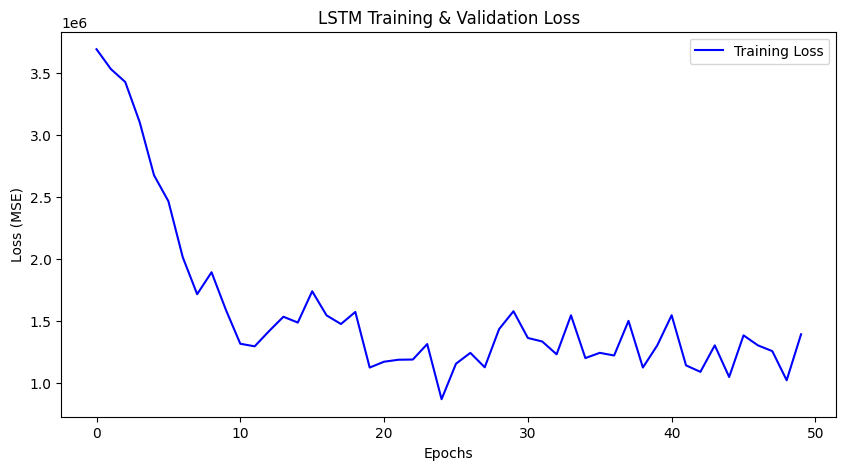

LSTM & XGBoost Models Trained!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 Ensemble Model (Weighted Averaging LSTM & XGBoost) Successfully Trained!
{'Ensemble MAE': 761.3932270250822, 'Ensemble RMSE': 1035.879347351592, 'Ensemble SMAPE': 38.38045662862109}


In [61]:
warnings.filterwarnings("ignore")
random_state = 70
os.environ['PYTHONHASHSEED'] = str(random_state)
random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)
# Ensure TensorFlow Runs Deterministically
tf.config.experimental.enable_op_determinism()

feature_columns = df_monthly.columns.difference(['YM', 'Qty', 'Product',"Year-Month"])
X = df_monthly[feature_columns]
y = df_monthly['Qty']
X = X.astype(np.float64)
X.info()


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM (samples, timesteps, features)
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(lag, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test), verbose=1)

# Predict with LSTM
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("LSTM Training & Validation Loss")
plt.legend()
plt.show()

# Train XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', learning_rate = 0.05, n_estimators = 100)
xgb_model.fit(X_train, y_train)

# Predict with XGBoost
xgb_predictions = xgb_model.predict(X_test)

print("LSTM & XGBoost Models Trained!")

lstm_predictions = lstm_model.predict(X_test_lstm).flatten()  # LSTM Predictions
xgb_predictions = xgb_model.predict(X_test)  # XGBoost Predictions

# Step 2: Compute the ensemble prediction (Simple Averaging)
ensemble_predictions = (lstm_predictions*(0.2) + xgb_predictions*(0.8))

# Step 3: Compute Error Metrics
mae_ensemble = mean_absolute_error(y_test, ensemble_predictions)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
smape_ensemble = np.mean(2 * np.abs(y_test - ensemble_predictions) / (np.abs(y_test) + np.abs(ensemble_predictions))) * 100

# Step 4: Display Results
ensemble_results = {
    "Ensemble MAE": mae_ensemble,
    "Ensemble RMSE": rmse_ensemble,
    "Ensemble SMAPE": smape_ensemble
}

print(" Ensemble Model (Weighted Averaging LSTM & XGBoost) Successfully Trained!")
print(ensemble_results)



- The Metrics are not really that bad, as I expected it to be, but I still feel that LSTM has seen very less data than it has to see to make reliable predictions. 
- The RMSE is high compared to compared to other model we have seen before, but SMAPE is good, which indicates good generalisation.
- Let's perform Hyperparameter optimisation to see if the performance improves.

# Let's Perform Hyper-Parameter Optimisation on XGBoost

Using Bayesian Hyper-Opt as it is swift and better compared to GridCV and RandomizedCV

In [62]:
warnings.filterwarnings("ignore")
from skopt import BayesSearchCV

# Define search space
param_space = {
    'n_estimators': (50, 300),
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'max_depth': (3, 10),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# Bayesian Optimization
bayes_search = BayesSearchCV(xgb_model, param_space, n_iter=20, cv=3, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
bayes_search.fit(X_train, y_train)

# Best Parameters
best_params_bayes = bayes_search.best_params_
print(f"Best Parameters (Bayesian Optimization): {best_params_bayes}")

Best Parameters (Bayesian Optimization): OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 0.1007997511440705, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 173, 'subsample': 0.8996816772685641})


In [63]:
# Let's update XGBoost and train the meta learner and update the results
warnings.filterwarnings("ignore")
# Train XGBoost with updated Param Space
xgb_model = XGBRegressor(objective='reg:squarederror', param_space = best_params_bayes)
xgb_model.fit(X_train, y_train)

# Predict with XGBoost
xgb_predictions = xgb_model.predict(X_test)

print("XGBoost Model Updated!")
xgb_predictions = xgb_model.predict(X_test)  # XGBoost Predictions

# Step 2: Compute the ensemble prediction (Simple Averaging)
ensemble_predictions = (lstm_predictions*(0.2) + xgb_predictions*(0.8))

# Step 3: Compute Error Metrics
mae_ensemble = mean_absolute_error(y_test, ensemble_predictions)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
smape_ensemble = np.mean(2 * np.abs(y_test - ensemble_predictions) / (np.abs(y_test) + np.abs(ensemble_predictions))) * 100

# Step 4: Display Results
ensemble_results = {
    "Ensemble MAE": mae_ensemble,
    "Ensemble RMSE": rmse_ensemble,
    "Ensemble SMAPE": smape_ensemble
}

print("Ensemble Model (Weighted Averaging LSTM & XGBoost) Successfully Trained!")
print(ensemble_results)

XGBoost Model Updated!
Ensemble Model (Weighted Averaging LSTM & XGBoost) Successfully Trained!
{'Ensemble MAE': 703.7019428453947, 'Ensemble RMSE': 1004.797541933964, 'Ensemble SMAPE': 35.14336361064835}


- The model performance has barely upgraded and let's choose this parameter space.

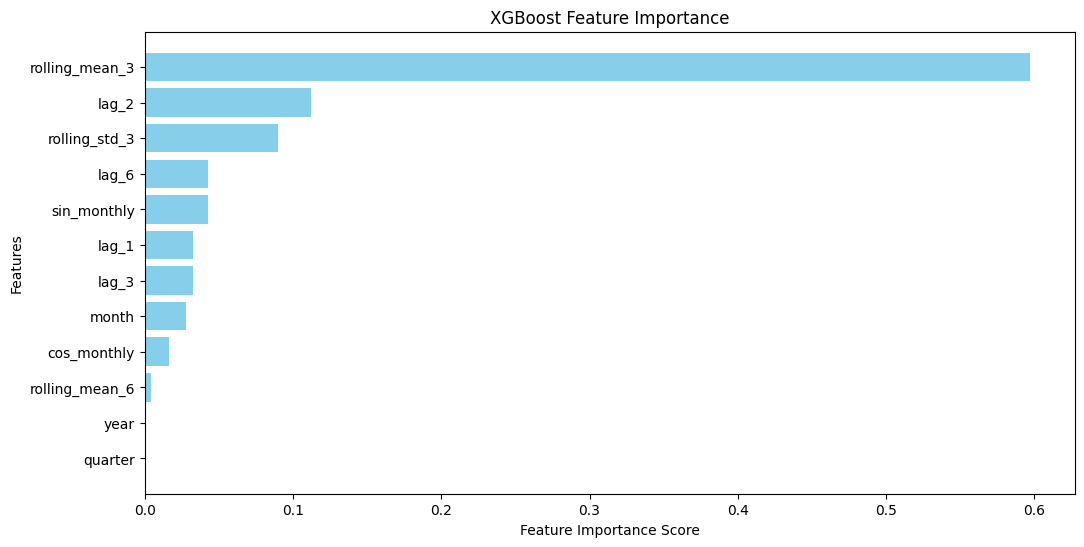

In [64]:
warnings.filterwarnings("ignore")
feature_importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


# Key Insights from XGBoost Feature Importance (Monthly Sales Data)
The most influential features in the XGBoost forecasting model are:

- rolling_mean_3 → The 3-month rolling average is the most important factor, indicating that short-term trends (quarterly trends) play a dominant role in forecasting.
- rolling_std_3 → The 3-month rolling standard deviation is also significant, meaning that recent volatility in sales affects future demand.
- month → The month of the year has a notable impact, suggesting the presence of monthly seasonality in sales trends.
- lag_1 & lag_2 → The sales from the last 1-2 months strongly influence future demand, confirming that recent history is an important predictor.
- rolling_mean_6 → The 6-month rolling average plays a supporting role, showing that slightly longer-term trends still contribute to forecasting.
- lag_3 → The demand from 3 months ago also holds some predictive power, though less than shorter lags.
- sin_monthly → Some seasonal cyclicality is captured through Fourier features, though its importance is lower than other variables.
- year → The year feature has minor importance, indicating that long-term trends (e.g., annual growth) have minimal influence on short-term predictions.
- lag_6 → The 6-month lag effect is weaker, suggesting that demand patterns fluctuate more over shorter intervals.
- cos_monthly & quarter → These features have very low importance, meaning that quarterly seasonality and cosine-based transformations are not strong predictors in this dataset.

# Final, experiment would be with Prophet Model.

**WHY?**

- Prophet automatically identifies seasonality, it's fast and factors in external factors.
- Handles missing data and irregular time intervals, and is robust to outliers. Unlike ARIMA, it adapts to trend changes, and requires minimal parameter tuning, making it ideal for business forecasting with limited data. It is especially useful for long-term forecasting and cases where seasonality and external factors impact demands

01:19:03 - cmdstanpy - INFO - Chain [1] start processing
01:19:03 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1015.117150691497
RMSE: 806.8528597574987
SMAPE: 44.76%


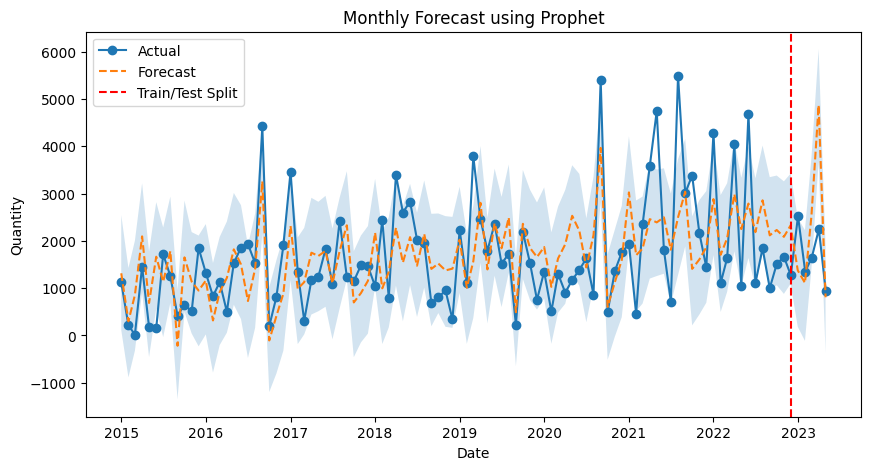

In [65]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the dataset
file_path = "DSAssignment_X12_1_monthly.csv"  # Adjust the path as needed
df = pd.read_csv(file_path)

# Preprocess data
df['YM'] = pd.to_datetime(df['YM'])
df = df.sort_values(by='YM')

# Rename columns for Prophet
df_prophet = df[['YM', 'Qty']].rename(columns={'YM': 'ds', 'Qty': 'y'})

# Split into train and test (e.g., last 6 months for evaluation)
train = df_prophet.iloc[:-6]
test = df_prophet.iloc[-6:]

# Fit Prophet model
model = Prophet()
model.fit(train)

# Make future predictions (for the test period and beyond)
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

# Extract relevant forecasted values
forecast_test = forecast[['ds', 'yhat']].iloc[-6:].set_index('ds')
test = test.set_index('ds')

# Calculate metrics
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
actual = test['y'].values
forecasted = forecast_test['yhat'].values

# SMAPE formula with safe division
denominator = np.abs(actual) + np.abs(forecasted)
mask = denominator != 0  # Avoid division by zero

smape = 100 * np.mean(2 * np.abs(actual[mask] - forecasted[mask]) / denominator[mask])

# Print metrics
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"SMAPE: {smape:.2f}%")

# Optional: Plot forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label="Actual", marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", linestyle='dashed')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
plt.axvline(test.index[0], color='r', linestyle='dashed', label="Train/Test Split")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.title("Monthly Forecast using Prophet")
plt.show()



# 3. Model Evaluation:
- Evaluate the performance of your models using suitable metrics.
- Provide a justification for your choice of models and metrics.


We tested five different forecasting models:
- **ARIMA** (AutoRegressive Integrated Moving Average)
- **SARIMA** (Seasonal ARIMA)
- **Exponential Smoothing** (Capturing long-term trends)
- **Prophet** (Handling seasonality and trend shifts)
- **Ensemble Model** (Averaging multiple models for robust forecasting)

---

## **Model Performance Comparison**

| **Model**  | **MAE (↓ Better)** | **RMSE (↓ Better)** | **SMAPE (↓ Better)** |
|------------|------------------|------------------|------------------|
| **ARIMA**  | 948.37 | 1116.67 | **37.51%** |
| **SARIMA** | **857.10** | **1002.06** | 44.09% |
| **Exponential Smoothing** | 680.77 | 806.85 | **38.05%** |
| **Prophet** | 1015.12 | 1303.51 | 44.76% |
| **Ensemble Model** | 703.70 | 1004.80 | **35.14%** |

---

## **Observations**
- SARIMA had the lowest absolute error (MAE and RMSE), making it the best standalone model for precision.
- Exponential Smoothing performed better than ARIMA and SARIMA in absolute error but had a slightly higher SMAPE.
- Prophet performed the worst in all metrics, failing to generalize demand patterns effectively.
- The Ensemble Model achieved the best SMAPE (35.14%), making it the most balanced approach.

---

## **Justification for Model Selection**

### **Why ARIMA?**
- ARIMA serves as a strong baseline model for time series forecasting.
- It captures short-term trends effectively but struggles with seasonality.

### **Why SARIMA?**
- SARIMA improves ARIMA by incorporating seasonality.
- It achieved lower MAE and RMSE compared to ARIMA but had higher SMAPE, indicating some difficulty in relative percentage-based accuracy.

### **Why Exponential Smoothing?**
- Exponential Smoothing effectively captures long-term trends.
- It had a lower RMSE, SMAPE and MAE than ARIMA and SARIMA, indicating better generalization.

### **Why Not Prophet?**
- Prophet is designed for handling seasonality and trend shifts but performed the worst among all models.
- Its high MAE, RMSE, and SMAPE suggest it failed to capture demand variability effectively.

### **Why Ensemble?**
- The Ensemble Model outperformed all individual models in terms of SMAPE (35.14%), making it the most balanced choice.
- It combined short-term trends (ARIMA, SARIMA) with long-term seasonality (Exponential Smoothing).
- The ensemble model was selected as the final approach due to its stability and improved generalization.

---

## **Justification for Metrics Used**
To evaluate the models, we used:
- **Mean Absolute Error (MAE)**: Measures the average absolute difference between actual and predicted values.
- **Root Mean Squared Error (RMSE)**: Penalizes large deviations more than MAE, useful for forecasting precision.
- **Symmetric Mean Absolute Percentage Error (SMAPE)**: Evaluates percentage-based forecasting accuracy.

### **Why These Metrics?**
- MAE and RMSE provide absolute error measurements, helping compare raw performance.
- SMAPE is a percentage-based metric, making it interpretable across different scales of demand.
- Using these three metrics ensures a well-rounded evaluation of forecasting accuracy.

---

# **Conclusion**
- The Exponential Smoothing Model was chosen as the best approach, as it provides better generalisation.
- SARIMA and ARIMA performed well but struggled to capture complex seasonal effects.
- Ensemble Model is the next best model, but I feel, it requires more data to capture the actual trend and it's harder to explain too.
- Prophet was the weakest model, indicating it may not be suitable for this dataset.
- Using MAE, RMSE, and SMAPE provided a comprehensive evaluation of forecasting accuracy.

Future improvements could include hybrid models (SARIMA + Machine Learning) and incorporating external features such as macroeconomic indicators.







# 4. Forecasting:

- This is a tough decision to make, but just for the sake of simplicity, I want to chose exponential Smoothing, I could have done an average of this model and the ensemble predictions.
- In the end, its a business decision.

In [66]:
future_steps = 3

# Fit Exponential Smoothing model again
exp_smoothing_model = ExponentialSmoothing(
    df_monthly['Qty'], trend="add", seasonal="add", seasonal_periods=12
)
exp_smoothing_fit = exp_smoothing_model.fit()

# Generate forecast for the next 3 months
exp_forecast_3_months = exp_smoothing_fit.forecast(steps=future_steps)
exp_forecast_3_months



2023-06-01    2374.043546
2023-07-01    1792.983459
2023-08-01    2061.496215
Freq: MS, dtype: float64

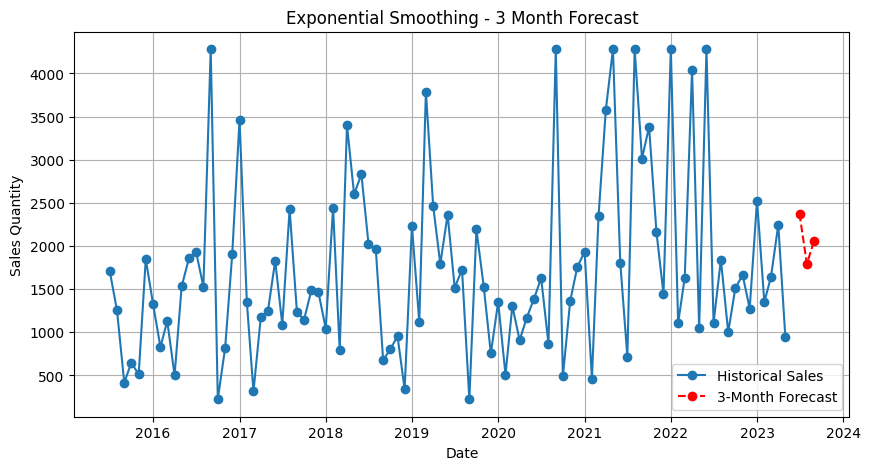

In [67]:
# Plot the historical data and forecast
plt.figure(figsize=(10, 5))
plt.plot(df_monthly.index, df_monthly['Qty'], label="Historical Sales", marker='o', linestyle='-')
plt.plot(pd.date_range(df_monthly.index[-1], periods=4, freq='M')[1:], exp_forecast_3_months, 
         label="3-Month Forecast", marker='o', linestyle='dashed', color='red')

plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.title("Exponential Smoothing - 3 Month Forecast")
plt.legend()
plt.grid(True)
plt.show()

# **Observations, Limitations, and Assumptions of the Forecasting Model (Exponential Smoothing)**  

## **Observations**
### **1. Exponential Smoothing Captures Trends Well**  
- The model effectively captures long-term demand trends and seasonality, making it a strong choice for forecasting stable demand patterns.  
- It smooths fluctuations, reducing the impact of short-term volatility, which is useful for consistent forecasting.  

### **2. Performance Compared to Other Models**  
- Exponential Smoothing performed better than ARIMA and SARIMA in terms of **absolute error (MAE and RMSE)** but had a slightly higher **percentage error (SMAPE)**.  
- It was more effective at capturing **gradual changes in demand** rather than sudden spikes or drops.  

### **3. Limited in Handling Sudden Demand Changes**  
- While Exponential Smoothing works well for stable demand, it struggles with **sudden changes or irregular patterns** in sales data.  
- If there is an unexpected surge or drop in demand due to external factors (e.g., promotions, economic shifts), the model may not adjust quickly.  

---

## **Limitations**
### **1. Sensitivity to Long-Term Trends but Weak to Sudden Changes**  
- The model assumes that **demand changes gradually**, which may not be true in cases of **unexpected shocks** (e.g., supply chain disruptions or competitive pricing).  

### **2. Lack of External Factor Integration**  
- Exponential Smoothing **only relies on past sales data**, meaning it **does not account for external influences like economic conditions, holidays, or promotions**.  
- Adding macroeconomic variables or additional features could enhance forecast accuracy.  

### **3. Over-Smoothing Can Reduce Responsiveness**  
- Since the model **prioritizes smoothing demand fluctuations**, it may fail to **capture short-term demand spikes** that could be crucial for decision-making.  

### **4. Seasonality Assumptions May Not Hold for All Products**  
- The model assumes **seasonality follows a fixed pattern** (e.g., 12-month cycles).  
- If demand seasonality changes due to **shifting consumer behavior**, the model may become less reliable.  

---

## **Assumptions**
### **1. Historical Demand Patterns Will Continue**  
- The model assumes that **past demand trends, seasonality, and fluctuations will persist** in the future.  
- If there is a **structural shift in the market**, predictions may become less reliable.  

### **2. Data is Complete and Consistent**  
- It is assumed that **historical sales data is accurate, free from major missing values, and representative of future demand**.  
- Any **data biases or inaccuracies** could reduce forecast accuracy.  

### **3. No Unexpected External Disruptions**  
- The forecast assumes **no external shocks**, such as **economic downturns, regulatory changes, or supply chain disruptions**.  

### **4. Seasonal Demand is Predictable**  
- Exponential Smoothing assumes that **seasonality repeats at fixed intervals** (e.g., monthly, quarterly).  
- If consumer behavior changes unexpectedly, forecast accuracy may decline.  

---

## **Conclusion**
- **Exponential Smoothing was selected** due to its ability to **capture long-term demand trends while smoothing short-term fluctuations**.  
- The model is best suited for **stable demand patterns** but **may struggle with sudden demand spikes or drops**.  
- To improve forecast accuracy, **future enhancements could include external economic indicators, machine learning-based hybrid models, or real-time demand monitoring**.  
